In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import sklearn.metrics as m
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import scipy.stats as stats

In [2]:
#CLEAN, PREPARE, AND MERGE DATA

demand_data = pd.read_csv('demand.csv')
prices_data = pd.read_csv('prices.csv')
households_data = pd.read_csv('households.csv')
temp_data = pd.read_csv('Temperaturer.csv', sep=';')
covid_data = pd.read_csv('OxCGRT_timeseries_GovernmentResponseIndex_v1.csv')

norway_data = covid_data[covid_data['CountryName'] == 'Norway']

norway_data = norway_data.dropna(axis=1)

norway_covid = norway_data.melt(
    id_vars=['CountryCode', 'CountryName', 'Jurisdiction'],
    var_name='Date_str',
    value_name='GovernmentResponseIndex'
)

# Convert the date string to datetime format
norway_covid['Date'] = pd.to_datetime(norway_covid['Date_str'], format='%d%b%Y')
norway_covid = norway_covid[['Date', 'GovernmentResponseIndex']]


print("\n=== Initial Data Shapes ===")
print(f"Demand data shape: {demand_data.shape}")
print(f"Prices data shape: {prices_data.shape}")
print(f"Households data shape: {households_data.shape}")
print(f"Temperature data shape: {temp_data.shape}")


# Clean column names and data
temp_data.columns = ['City', 'Timestamp_UTC', 'Temperature', 'Temperature24', 'Temperature48', 'Temperature72']

# Convert timestamp to datetime
temp_data['Timestamp_UTC'] = pd.to_datetime(temp_data['Timestamp_UTC'])

# Convert temperature to numeric, replacing , with .
temp_data['Temperature24'] = temp_data['Temperature24'].str.replace(',', '.').astype(float)
temp_data['Temperature72'] = temp_data['Temperature72'].str.replace(',', '.').astype(float)


# Create Date and Hour columns to match with demand data
temp_data['Date'] = pd.to_datetime(temp_data['Timestamp_UTC'].dt.date)
temp_data['Hour'] = temp_data['Timestamp_UTC'].dt.hour


city_to_area = {
    'Oslo': 'NO1',
    'Sarpsborg': 'NO1',
    'Moss': 'NO1',
    'Bergen': 'NO5'
}

temp_data['Price_area'] = temp_data['City'].map(city_to_area)
temp_data = temp_data[['Date', 'Hour', 'Price_area', 'Temperature24', 'Temperature72']]

#Prepare temp_data for merging, avoiding duplicates
temp_data = temp_data.groupby(['Price_area', 'Date', 'Hour'], as_index=False).agg({
    'Temperature24': 'mean',
    'Temperature72': 'mean'
})

print("\n=== Temperature data after grouping ===")
print(f"Shape of unique temperature data: {temp_data.shape}")


#1Merge demand_data and households_data
merged_data = pd.merge(demand_data, households_data[['ID', 'Price_area']], on='ID', how='left')
print("\n=== After first merge ===")
print(f"Shape after merging with households: {merged_data.shape}")
print(f"Number of duplicate rows after merge: {merged_data.duplicated().sum()}")

#2Merge merged_data and prices_data
merged_data = pd.merge(merged_data, prices_data[['Price_area', 'Date', 'Hour', 'Price_NOK_MWh', 'Price_NOK_kWh']],
                      on=['Price_area', 'Date', 'Hour'], how='left')
print("\n=== After second merge ===")
print(f"Shape after merging with prices: {merged_data.shape}")
print(f"Number of duplicate rows after merge: {merged_data.duplicated().sum()}")

merged_data['Date'] = pd.to_datetime(merged_data['Date']) #needed

#3Final merge of merged_data and temp_data
merged_data = pd.merge(merged_data, temp_data,
                      on=['Price_area', 'Date', 'Hour'],
                      how='left')

print("\n=== After third merge ===")
print(f"Shape after merging with temperature: {merged_data.shape}")
print(f"Number of duplicate rows after merge: {merged_data.duplicated().sum()}")

#4Final merge of merged_data and norway_covid
merged_data = pd.merge(
    merged_data,
    norway_covid,
    on='Date',
    how='left'
)

print("\n=== After COVID data merge ===")
print(f"Shape after merging with COVID data: {merged_data.shape}")
print(f"Number of duplicate rows after merge: {merged_data.duplicated().sum()}")


norwegian_holidays = {
    '2021-01-01': 'New Year\'s Day',
    '2021-04-01': 'Maundy Thursday',
    '2021-04-02': 'Good Friday',
    '2021-04-04': 'Easter Sunday',
    '2021-04-05': 'Easter Monday',
    '2021-05-01': 'Labour Day',
    '2021-05-13': 'Ascension Day',
    '2021-05-17': 'Constitution Day',
    '2021-05-23': 'Pentecost Sunday',
    '2021-05-24': 'Whit Monday',
    '2021-12-25': 'Christmas Day',
    '2021-12-26': 'Boxing Day',

    '2022-01-01': 'New Year\'s Day',
    '2022-04-14': 'Maundy Thursday',
    '2022-04-15': 'Good Friday',
    '2022-04-17': 'Easter Sunday',
    '2022-04-18': 'Easter Monday',
    '2022-05-01': 'Labour Day',
    '2022-05-17': 'Constitution Day',
    '2022-05-26': 'Ascension Day',
    '2022-06-05': 'Pentecost Sunday',
    '2022-06-06': 'Whit Monday',
    '2022-12-25': 'Christmas Day',
    '2022-12-26': 'Boxing Day'
}

holidays_df = pd.DataFrame({
    'Date': pd.to_datetime(list(norwegian_holidays.keys())),
    'HolidayName': list(norwegian_holidays.values())
})

merged_data['IsHoliday'] = 0
merged_data.loc[merged_data['Date'].isin(holidays_df['Date']), 'IsHoliday'] = 1

christmas_period_2021 = pd.date_range(start='2021-12-27', end='2021-12-31')
christmas_period_2022 = pd.date_range(start='2022-12-27', end='2022-12-31')

merged_data.loc[merged_data['Date'].isin(christmas_period_2021), 'IsHoliday'] = 1
merged_data.loc[merged_data['Date'].isin(christmas_period_2022), 'IsHoliday'] = 1

print(f"Total holidays marked: {merged_data['IsHoliday'].sum()}")
print(f"Percentage of holiday days: {merged_data['IsHoliday'].mean()*100:.2f}%")





print("\n=== Creating High-Price Dataset ===")
high_price_data = merged_data[
    (merged_data['Price_NOK_kWh'] > 0.7) & 
    (merged_data['Demand_kWh'] > 0)
].copy()

print(f"\nOriginal dataset: {len(merged_data)} observations")
print(f"High-price subset: {len(high_price_data)} observations ({len(high_price_data)/len(merged_data)*100:.1f}%)")

high_price_data['log_Demand'] = np.log(high_price_data['Demand_kWh'])
high_price_data['log_Price'] = np.log(high_price_data['Price_NOK_kWh'])

shock_date = pd.to_datetime('2021-09-01')
high_price_data['Post_shock'] = (high_price_data['Date'] >= shock_date).astype(int)


print("\n=== High-Price Data Quality Check ===")
print(f"Final high-price dataset shape: {high_price_data.shape}")
print(f"Unique households: {high_price_data['ID'].nunique()}")
print(f"Date range: {high_price_data['Date'].min()} to {high_price_data['Date'].max()}")
print("\nMissing values in high-price data:")
print(high_price_data[['log_Demand', 'log_Price', 'Temperature24', 'IsHoliday']].isnull().sum())

print("\n=== High-Price Descriptive Stats ===")
print(f"Average high price: {high_price_data['Price_NOK_kWh'].mean():.3f} NOK/kWh")
print(f"Price range: {high_price_data['Price_NOK_kWh'].min():.3f}-{high_price_data['Price_NOK_kWh'].max():.3f} NOK/kWh")
print(f"Households with sufficient data (>100 obs): {(high_price_data['ID'].value_counts() >= 100).sum()}")


 #First try forward fill within each day
high_price_data['Temperature24'] = high_price_data.groupby(['Price_area', 'Date'])['Temperature24'].transform(
    lambda x: x.ffill()
)

# Then try backward fill for any remaining missing values
high_price_data['Temperature24'] = high_price_data.groupby(['Price_area', 'Date'])['Temperature24'].transform(
    lambda x: x.bfill()
)

# Same for Temperature72 which might also have missing values
high_price_data['Temperature72'] = high_price_data.groupby(['Price_area', 'Date'])['Temperature72'].transform(
    lambda x: x.ffill().bfill()
)

# 2. Check if we still have missing values after filling
missing_temp = high_price_data['Temperature24'].isna().sum()
print(f"Missing Temperature24 values after ffill/bfill: {missing_temp}")


=== Initial Data Shapes ===
Demand data shape: (14913408, 4)
Prices data shape: (135240, 5)
Households data shape: (4446, 5)
Temperature data shape: (1115472, 6)

=== Temperature data after grouping ===
Shape of unique temperature data: (248208, 5)

=== After first merge ===
Shape after merging with households: (14913408, 5)
Number of duplicate rows after merge: 0

=== After second merge ===
Shape after merging with prices: (14913408, 7)
Number of duplicate rows after merge: 0

=== After third merge ===
Shape after merging with temperature: (14913408, 9)
Number of duplicate rows after merge: 0

=== After COVID data merge ===
Shape after merging with COVID data: (14913408, 10)
Number of duplicate rows after merge: 0
Total holidays marked: 490752
Percentage of holiday days: 3.29%

=== Creating High-Price Dataset ===

Original dataset: 14913408 observations
High-price subset: 6477185 observations (43.4%)

=== High-Price Data Quality Check ===
Final high-price dataset shape: (6477185, 14)


=== Enhanced Consumption Change Analysis ===
Total households analyzed: 1136
Households after outlier removal: 1114 (98.1% of total)
Outliers removed: 22

Percentage Change Distribution (without outliers):
count    1114.000000
mean      -15.171562
std        23.576314
min       -96.489755
25%       -27.428716
50%       -15.213486
75%        -2.729669
90%        10.672919
max        97.061653
Name: Pct_Change, dtype: float64

Actual kWh Change Distribution (without outliers):
count    1114.000000
mean        0.342021
std         0.428889
min        -0.900116
25%         0.023888
50%         0.223587
75%         0.557338
90%         0.895085
max         2.337294
Name: kWh_Difference, dtype: float64

Behavioral Classification (without outliers):
Reduced      70.017953
No Change    16.068223
Increased    13.913824
Name: Change_Type, dtype: float64


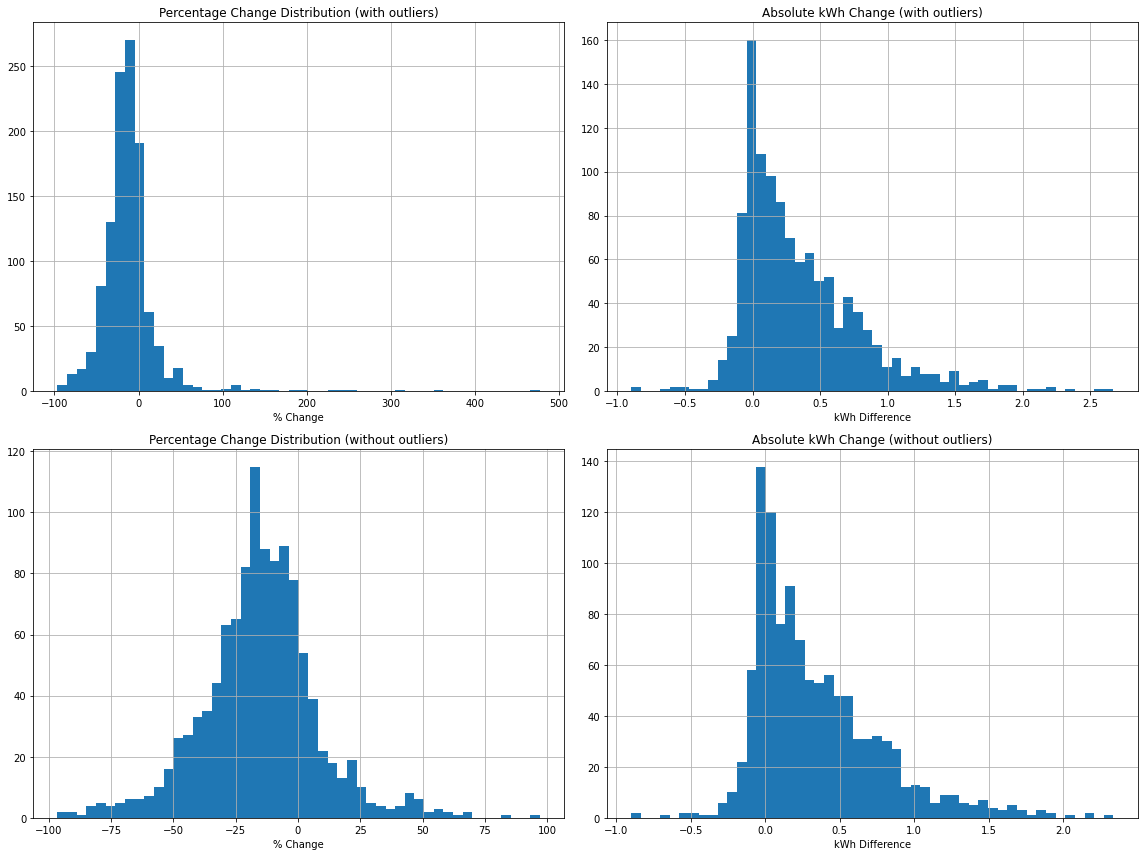


=== Pure Consumption Change Analysis (without outliers) ===
Average post-shock effect (log units): -0.2134
Percentage with reduced consumption: 80.1%

Average consumption change: -19.2%

Median pre-shock consumption: 1.77 kWh
Median post-shock consumption: 2.81 kWh

Household Percentage Changes (without outliers):
   Household_ID  Percentage_Change
0            18         -58.789523
1            23         -22.622194
2            30         -82.803087
3            31          -8.944713
4            34         -16.702032
   ID  Q_Age  Q_Gender  Q_City  Q1  Q4  Q7  Q13_1  Q13_2  Q13_3  ...  Q27_5  \
0  18     71         1       4   2   3   3      1      1      0  ...      0   
1  19     56         2       7   1   2   1      1      0      0  ...      0   
2  20     25         2       5   2   5   3      0      0      0  ...      0   
3  23     65         2       5   1   1   2      1      0      0  ...      0   
4  24     59         2       7   2   2   2      1      1      0  ...      1   

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from joblib import Parallel, delayed


def prepare_high_price_data(household_df, hh_id, include_price=False):  # Added include_price parameter
    try:
        household_df = household_df.copy()
        
        # Same feature engineering as before
        household_df['Month'] = household_df['Date'].dt.month
        household_df['Hour'] = household_df['Hour']
        household_df['Weekday'] = household_df['Date'].dt.weekday
        household_df['IsHoliday'] = household_df['IsHoliday'].astype(int)
        household_df['T24h_sq'] = household_df['Temperature24']**2
        household_df['T24h_cb'] = household_df['Temperature24']**3
        
        # Feature matrix - conditionally include price
        base_features = [
            'Temperature24', 'T24h_sq', 'T24h_cb',
            'Temperature72', 'Month', 'Hour',
            'Weekday', 'IsHoliday', 'GovernmentResponseIndex',
            'Post_shock'  # Keep shock indicator
        ]
        
        if include_price:
            base_features.append('log_Price')
        
        X = household_df[base_features].copy()
        y = household_df['log_Demand']
        
        # Only add interaction if price is included
        if include_price:
            X['log_Price_x_Post_shock'] = X['log_Price'] * X['Post_shock']
        
        X = pd.get_dummies(X, columns=['Month', 'Hour', 'Weekday', 'IsHoliday'],
                         drop_first=True)
        
        X = sm.add_constant(X)
        
        return X, y
    except Exception as e:
        print(f"Error preparing household {hh_id}: {str(e)}")
        return None, None

def estimate_consumption_change(household_df, hh_id):
    """Estimate pure consumption changes (without price effects)"""
    try:
        # Get data WITHOUT price variables
        X, y = prepare_high_price_data(household_df, hh_id, include_price=False)
        
        if X is None or y is None:
            print(f"Household {hh_id}: Data preparation failed")
            return None
            
        if len(X) < 30:
            print(f"Household {hh_id}: Insufficient observations ({len(X)})")
            return None
            
        model = sm.OLS(y, X).fit()
        
        return {
            'ID': hh_id,
            'Post_Shock_effect': model.params['Post_shock'],  # Pure shock effect
            'N_Obs': len(X),
            'R2': model.rsquared,
            'Post_Shock_SE': model.bse['Post_shock'],
            'Pre_Shock_obs': sum(X['Post_shock'] == 0),
            'Post_Shock_obs': sum(X['Post_shock'] == 1),
            'Avg_consumption': np.exp(y.mean())  # Actual kWh in original units
        }
    
    except Exception as e:
        print(f"Error modeling household {hh_id}: {str(e)}")
        return None

def run_consumption_analysis(high_price_data, n_jobs=2):
    """Run analysis for pure consumption changes"""
    hh_ids = high_price_data['ID'].unique()
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(estimate_consumption_change)(
            high_price_data[high_price_data['ID'] == hh_id],
            hh_id
        )
        for hh_id in hh_ids
    )
    
    return pd.DataFrame([r for r in results if r is not None])

def analyze_consumption_changes(consumption_results, high_price_data, 
                             pct_outlier_threshold=100, kwh_outlier_threshold=2.5):
    """Comprehensive analysis of consumption changes with outlier handling"""
    # Convert log effects to percentage changes
    consumption_results['Pct_Change'] = (np.exp(consumption_results['Post_Shock_effect']) - 1) * 100
    
    # Merge with original data to get actual consumption values
    hh_consumption = high_price_data.groupby(['ID', 'Post_shock'])['log_Demand'].agg(
        ['mean', 'count']).unstack()
    hh_consumption.columns = ['Pre_Mean', 'Post_Mean', 'Pre_Count', 'Post_Count']
    
    # Convert from log to kWh
    hh_consumption = hh_consumption.join(
        consumption_results.set_index('ID')[['Pct_Change', 'Post_Shock_effect']]
    )
    
    # Calculate actual kWh values
    hh_consumption['Pre_kWh'] = np.exp(hh_consumption['Pre_Mean'])
    hh_consumption['Post_kWh'] = np.exp(hh_consumption['Post_Mean'])
    hh_consumption['kWh_Difference'] = hh_consumption['Post_kWh'] - hh_consumption['Pre_kWh']
    
    # Mark outliers
    hh_consumption['Is_Pct_Outlier'] = (abs(hh_consumption['Pct_Change']) > pct_outlier_threshold)
    hh_consumption['Is_kWh_Outlier'] = (abs(hh_consumption['kWh_Difference']) > kwh_outlier_threshold)
    hh_consumption['Is_Outlier'] = (hh_consumption['Is_Pct_Outlier'] | hh_consumption['Is_kWh_Outlier'])
    
    # Classify households
    conditions = [
        (hh_consumption['Pct_Change'] < -5),
        (hh_consumption['Pct_Change'] > 5),
        (abs(hh_consumption['Pct_Change']) <= 5)
    ]
    choices = ['Reduced', 'Increased', 'No Change']
    hh_consumption['Change_Type'] = np.select(conditions, choices)
    
    return hh_consumption

# The main execution block
if __name__ == "__main__":
    # Assuming high_price_data is available
    # You need to load or define high_price_data first
    
    # 1. First run the consumption analysis to create consumption_results
    consumption_results = run_consumption_analysis(high_price_data)
    
    # 2. Then analyze those results to create detailed_results
    detailed_results = analyze_consumption_changes(consumption_results, high_price_data, 
                                               pct_outlier_threshold=100, kwh_outlier_threshold=2.5)
    
    # Create a filtered version without outliers
    filtered_results = detailed_results[~detailed_results['Is_Outlier']].copy()
    
    # Generate comprehensive report
    print("\n=== Enhanced Consumption Change Analysis ===")
    print(f"Total households analyzed: {len(detailed_results)}")
    print(f"Households after outlier removal: {len(filtered_results)} ({len(filtered_results)/len(detailed_results)*100:.1f}% of total)")
    print(f"Outliers removed: {len(detailed_results) - len(filtered_results)}")
    
    print("\nPercentage Change Distribution (without outliers):")
    print(filtered_results['Pct_Change'].describe(percentiles=[.25, .5, .75, .9]))
    
    print("\nActual kWh Change Distribution (without outliers):")
    print(filtered_results['kWh_Difference'].describe(percentiles=[.25, .5, .75, .9]))
    
    print("\nBehavioral Classification (without outliers):")
    print(filtered_results['Change_Type'].value_counts(normalize=True) * 100)
    
    # Plotting with and without outliers
    import matplotlib.pyplot as plt
    
    # Plot 1: Original data with outliers
    plt.figure(figsize=(16, 12))
    
    plt.subplot(2, 2, 1)
    detailed_results['Pct_Change'].hist(bins=50)
    plt.title("Percentage Change Distribution (with outliers)")
    plt.xlabel("% Change")
    
    plt.subplot(2, 2, 2)
    detailed_results['kWh_Difference'].hist(bins=50)
    plt.title("Absolute kWh Change (with outliers)")
    plt.xlabel("kWh Difference")
    
    # Plot 2: Filtered data without outliers
    plt.subplot(2, 2, 3)
    filtered_results['Pct_Change'].hist(bins=50)
    plt.title("Percentage Change Distribution (without outliers)")
    plt.xlabel("% Change")
    
    plt.subplot(2, 2, 4)
    filtered_results['kWh_Difference'].hist(bins=50)
    plt.title("Absolute kWh Change (without outliers)")
    plt.xlabel("kWh Difference")
    
    plt.tight_layout()
    plt.show()
    
    # Output household-level results
    filtered_results[['Pre_kWh', 'Post_kWh', 'kWh_Difference', 'Pct_Change', 'Change_Type']].sort_values('Pct_Change').to_csv("household_consumption_changes_filtered.csv")
    
    # Save both filtered and unfiltered data
    detailed_results[['Pre_kWh', 'Post_kWh', 'kWh_Difference', 'Pct_Change', 'Change_Type', 'Is_Outlier']].sort_values('Pct_Change').to_csv("household_consumption_changes_all.csv")
    
    # Analyze results (using filtered data)
    print("\n=== Pure Consumption Change Analysis (without outliers) ===")
    filtered_consumption_results = consumption_results[consumption_results['ID'].isin(filtered_results.index)]
    print(f"Average post-shock effect (log units): {filtered_consumption_results['Post_Shock_effect'].mean():.4f}")
    print(f"Percentage with reduced consumption: {(filtered_consumption_results['Post_Shock_effect'] < 0).mean()*100:.1f}%")
    
    # Convert to percentage change for interpretation
    avg_effect = np.exp(filtered_consumption_results['Post_Shock_effect'].mean()) - 1
    print(f"\nAverage consumption change: {avg_effect*100:.1f}%")
    
    # Get actual kWh changes
    pre_consumption = np.exp(filtered_consumption_results['Avg_consumption'] / 
                      (1 + np.exp(filtered_consumption_results['Post_Shock_effect'])))
    post_consumption = np.exp(filtered_consumption_results['Avg_consumption'])
    
    print(f"\nMedian pre-shock consumption: {np.median(pre_consumption):.2f} kWh")
    print(f"Median post-shock consumption: {np.median(post_consumption):.2f} kWh")
    
    # Create simplified percentage change dataframe
    percent_change_df = filtered_results[['Pct_Change']].copy().reset_index()
    percent_change_df.columns = ['Household_ID', 'Percentage_Change']
    
    # Show sample
    print("\nHousehold Percentage Changes (without outliers):")
    print(percent_change_df.head())
    
    # Save to CSV
    percent_change_df.to_csv('household_percentage_changes_filtered.csv', index=False)
    
survey_data = pd.read_csv('answers.csv')
survey_data = survey_data.dropna(axis=1)

#add price elacticity to survey data
percent_change_df = percent_change_df.rename(columns={'Household_ID': 'ID'})

df_survey_PE = pd.merge(survey_data, percent_change_df,
                      on=['ID'],
                      how='left')

print(df_survey_PE.head())
print(df_survey_PE.shape)

df_survey_PE = df_survey_PE.dropna(axis=0)
#save data as csv, to use for machine learning in different file named 'FeatureSelection'
df_survey_PE.to_csv('survey_PE12345.csv', index=False) 


In [4]:
pos_price_response = (high_price_results['High_Price_elasticity'] > 0).mean() * 100
print(f"\nPercentage of households with positive price response: {pos_price_response:.2f}%")
print(f"Percentage with negative elasticity: {(high_price_results['High_Price_elasticity'] < 0).mean()*100:.1f}%")
print(f"Percentage with positive elasticity: {(high_price_results['High_Price_elasticity'] > 0).mean()*100:.1f}%")

# For post-shock elasticity
high_price_results['Post_Shock_Elasticity'] = (
    high_price_results['High_Price_elasticity'] + 
    high_price_results['Price_Shock_interaction']
)

# Then analyze both:
print("Pre-shock elasticity distribution:")
print(high_price_results['High_Price_elasticity'].describe())

print("\nPost-shock elasticity distribution:")
print(high_price_results['Post_Shock_Elasticity'].describe())

# Calculate post-shock elasticity for each household
high_price_results['Post_shock_elasticity'] = high_price_results['High_Price_elasticity'] + high_price_results['Price_Shock_interaction']

# Check percentage of households with negative post-shock elasticity
post_shock_negative = (high_price_results['Post_shock_elasticity'] < 0).mean() * 100
print(f"Percentage with negative post-shock elasticity: {post_shock_negative:.1f}%")

# Check distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(high_price_results['High_Price_elasticity'], bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title("Baseline Elasticity (Pre-shock)")
plt.xlabel("Elasticity")

plt.subplot(1, 2, 2)
plt.hist(high_price_results['Post_shock_elasticity'], bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title("Post-shock Elasticity")
plt.xlabel("Elasticity")
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Histogram of elasticities
plt.subplot(1, 2, 1)
sns.histplot(high_price_results['High_Price_elasticity'], bins=30, kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.axvline(x=high_price_results['High_Price_elasticity'].median(), color='g', linestyle='-')
plt.title('Distribution of Price Elasticities')
plt.xlabel('Elasticity Coefficient')
plt.ylabel('Number of Households')

# Scatter plot of elasticity vs R-squared
plt.subplot(1, 2, 2)
sns.scatterplot(x='High_Price_elasticity', y='R2', data=high_price_results, alpha=0.6)
plt.title('Elasticity vs Model Fit (R²)')
plt.axvline(x=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(high_price_results['High_Price_elasticity'], 
         alpha=0.5, label='Pre-Shock', bins=30)
plt.hist(high_price_results['Post_Shock_Elasticity'], 
         alpha=0.5, label='Post-Shock', bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.legend()
plt.xlabel('Price Elasticity')
plt.ylabel('Number of Households')
plt.title('Elasticity Distribution Before/After Price Shock')
plt.show()


from scipy import stats

# Calculate confidence intervals for post-shock elasticities
confidence_level = 0.95
t_critical = stats.t.ppf(1 - (1 - confidence_level)/2, df=len(high_price_results)-1)

# Calculate lower and upper bounds for each elasticity
high_price_results['Post_Shock_Lower'] = (
    high_price_results['Post_Shock_Elasticity'] - 
    t_critical * high_price_results['Post_Shock_SE']
)
high_price_results['Post_Shock_Upper'] = (
    high_price_results['Post_Shock_Elasticity'] + 
    t_critical * high_price_results['Post_Shock_SE']
)

# Find the thresholds:
# For positive elasticities: the smallest elasticity where lower bound > 0
positive_threshold = high_price_results[
    high_price_results['Post_Shock_Lower'] > 0
]['Post_Shock_Elasticity'].min()

# For negative elasticities: the largest elasticity where upper bound < 0
negative_threshold = high_price_results[
    high_price_results['Post_Shock_Upper'] < 0
]['Post_Shock_Elasticity'].max()

print(f"Positive elasticity threshold (lower bound > 0): {positive_threshold:.4f}")
print(f"Negative elasticity threshold (upper bound < 0): {negative_threshold:.4f}")

# For insignificant elasticities, the range where CI includes 0
insignificant_lower = negative_threshold
insignificant_upper = positive_threshold

print(f"\nClassification ranges:")
print(f"Negative: elasticity ≤ {negative_threshold:.4f}")
print(f"Insignificant: {negative_threshold:.4f} < elasticity < {positive_threshold:.4f}")
print(f"Positive: elasticity ≥ {positive_threshold:.4f}")

import pandas as pd
from scipy import stats

# Assuming your DataFrame is named 'high_price_results'
# and has columns 'Post_Shock_Elasticity' and 'Post_Shock_SE'

# Degrees of freedom (n - 1)
df = len(high_price_results) - 1

# Calculate t-statistics and p-values
high_price_results['t_stat'] = (
    high_price_results['Post_Shock_Elasticity'] / 
    high_price_results['Post_Shock_SE']
)

high_price_results['p_value'] = 2 * (1 - stats.t.cdf(
    abs(high_price_results['t_stat']), 
    df=df
))

# Classify significance (e.g., at alpha = 0.05)
high_price_results['Significant'] = high_price_results['p_value'] < 0.05

# Print results
print(high_price_results[['Post_Shock_Elasticity', 'Post_Shock_SE', 't_stat', 'p_value', 'Significant']].head())

# Summary counts
print("\nSignificance Counts:")
print(high_price_results['Significant'].value_counts())

t_stat_pre, p_value_pre = stats.ttest_1samp(high_price_results['High_Price_elasticity'], 0)
print(f"Pre-shock overall elasticity p-value: {p_value_pre:.4f}")

# Test if mean post-shock elasticity is different from zero
t_stat_post, p_value_post = stats.ttest_1samp(high_price_results['Post_Shock_Elasticity'], 0)
print(f"Post-shock overall elasticity p-value: {p_value_post:.4f}")

NameError: name 'high_price_results' is not defined

In [ ]:
#PREPARE DATA FOR MACHINE LEARNING BY MAKING DATASET WITH SURVEY DATA AS THE FEATURES AND PRICE ELASTICITY AS THE TARGET


high_price_results['Post_Shock_Elasticity'] = (
    high_price_results['High_Price_elasticity'] + 
    high_price_results['Price_Shock_interaction']
)

# Rename the target variable
high_price_results = high_price_results.rename(columns={'Post_Shock_Elasticity': 'Price_elasticity'})

survey_data = pd.read_csv('answers.csv')
survey_data = survey_data.dropna(axis=1)

#add price elacticity to survey data
df_PE = high_price_results[['ID', 'Price_elasticity']]
df_survey_PE = pd.merge(survey_data, df_PE,
                      on=['ID'],
                      how='left')

print(df_survey_PE.head())
print(df_survey_PE.shape)

df_survey_PE = df_survey_PE.dropna(axis=0)
#save data as csv, to use for machine learning in different file named 'FeatureSelection'
df_survey_PE.to_csv('survey_PE.csv', index=False) 

print(df_survey_PE.shape)

#CORRELATION MATRIX
corr_matrix = df_survey_PE.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0,
            linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()

# Calculate correlations with Price_elasticity (sorted by absolute value)
corr_with_target = df_survey_PE.corr()[['Price_elasticity']].drop('Price_elasticity')
corr_with_target['abs_corr'] = corr_with_target['Price_elasticity'].abs()  # Absolute value for ranking
corr_with_target_sorted = corr_with_target.sort_values('abs_corr', ascending=False)

print("Top features correlated with Price_elasticity:")
print(corr_with_target_sorted.drop(columns=['abs_corr']).head(10))  # Show top 10

plt.figure(figsize=(10, 6))
sns.barplot(
    x=corr_with_target_sorted['Price_elasticity'].head(10), 
    y=corr_with_target_sorted.index[:10],
    palette='viridis'
)
plt.title("Top 10 Features Correlated with Price Elasticity")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Prepare the data according to the model specification
def prepare_model_data(merged_data):
    # Ensure positive values for log transform
    merged_data = merged_data[(merged_data['Demand_kWh'] > 0)].copy()
    
    # Create log of electricity demand (dependent variable)
    merged_data['log_E'] = np.log(merged_data['Demand_kWh'])
    
    # Create dummy variables for price shock periods (Dx)
    # You'll need to define your price shock periods based on your data
    # This is just an example - adjust according to your study design
    merged_data['Dx_post_shock'] = (merged_data['Date'] >= '2022-01-01').astype(int)  # Example date
    
    # Temperature variables
    merged_data['T24h'] = merged_data['Temperature24']  # 24-hour moving average
    merged_data['T24h_sq'] = merged_data['T24h']**2     # Quadratic term
    merged_data['T24h_cb'] = merged_data['T24h']**3     # Cubic term
    merged_data['T72h'] = merged_data['Temperature72']  # 72-hour moving average
    
    # Time-related dummy variables
    merged_data['Month'] = merged_data['Date'].dt.month
    merged_data['Hour'] = merged_data['Hour']
    merged_data['Weekday'] = merged_data['Date'].dt.weekday  # Monday=0, Sunday=6
    merged_data['IsHoliday'] = merged_data['IsHoliday'].astype(int)  # Should be 0/1
    
    # COVID stringency index
    merged_data['Ccovid'] = merged_data['GovernmentResponseIndex']
    
    # Bidding area dummies (if applicable)
    if 'BiddingArea' in merged_data.columns:
        merged_data = pd.get_dummies(merged_data, columns=['BiddingArea'], prefix='Dbarea')
    
    return merged_data

# Prepare the data
model_data = prepare_model_data(merged_data)

# Function to run the regression model
def run_electricity_model(data):
    # Create dummy variables for categorical features
    month_dummies = pd.get_dummies(data['Month'], prefix='month', drop_first=True)
    hour_dummies = pd.get_dummies(data['Hour'], prefix='hour', drop_first=True)
    weekday_dummies = pd.get_dummies(data['Weekday'], prefix='wday', drop_first=True)
    
    # Create interaction terms
    data['hour_holiday'] = data['Hour'].astype(str) + "_" + data['IsHoliday'].astype(str)
    hour_holiday_dummies = pd.get_dummies(data['hour_holiday'], prefix='hh', drop_first=True)
    
    data['hour_weekday'] = data['Hour'].astype(str) + "_" + data['Weekday'].astype(str)
    hour_weekday_dummies = pd.get_dummies(data['hour_weekday'], prefix='hw', drop_first=True)
    
    data['hour_temp'] = data['Hour'].astype(str) + "_" + pd.qcut(data['T72h'], 4).astype(str)
    hour_temp_dummies = pd.get_dummies(data['hour_temp'], prefix='ht', drop_first=True)
    
    # Combine all features
    X = pd.concat([
        data[['Dx_post_shock', 'T24h', 'T24h_sq', 'T24h_cb', 'T72h', 'Ccovid']],
        month_dummies,
        hour_dummies,
        weekday_dummies,
        hour_holiday_dummies,
        hour_weekday_dummies,
        hour_temp_dummies
    ], axis=1)
    
    # Add bidding area dummies if they exist
    if any(col.startswith('Dbarea_') for col in data.columns):
        bidding_area_dummies = data.filter(regex='^Dbarea_')
        X = pd.concat([X, bidding_area_dummies], axis=1)
    
    # Add constant (intercept)
    X = sm.add_constant(X)
    
    # Dependent variable
    y = data['log_E']
    
    # Drop any rows with missing values
    complete_cases = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[complete_cases]
    y = y[complete_cases]
    
    # Weighted least squares (if you have household weights)
    # For this example, we'll use OLS, but you can add weights if available
    model = sm.OLS(y, X).fit()
    
    return model

def process_in_chunks(data, model_function, chunk_size=100000):
    """
    Process data in chunks to avoid memory errors
    Args:
        data: Full DataFrame
        model_function: The modeling function to apply to each chunk
        chunk_size: Number of rows per chunk
    Returns:
        Combined model results
    """
    results = []
    for i in range(0, len(data), chunk_size):
        print(f"Processing chunk {i//chunk_size + 1}/{(len(data)//chunk_size)+1}")
        chunk = data.iloc[i:i+chunk_size].copy()
        
        # Run model on current chunk
        chunk_result = model_function(chunk)
        results.append(chunk_result)
    
    # Simple combination - average coefficients (you may need more sophisticated combination)
    combined_params = pd.concat([r.params for r in results]).groupby(level=0).mean()
    
    # Create dummy final model object (this is simplified)
    final_model = results[0]
    final_model.params = combined_params
    return final_model

# New chunked processing version
model = process_in_chunks(
    data=model_data,
    model_function=run_electricity_model,
    chunk_size=20000  # Adjust based on your memory
)

# Print model summary
print(model.summary())

# Diagnostic tests
print("\n=== Model Diagnostics ===")
print("Jarque-Bera test for normality:", sm.stats.jarque_bera(model.resid))
print("Breusch-Pagan test for heteroskedasticity:", sm.stats.het_breuschpagan(model.resid, model.model.exog))

# VIF for multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = model.model.exog_names
vif_data["VIF"] = [variance_inflation_factor(model.model.exog, i) for i in range(model.model.exog.shape[1])]
print("\nVariance Inflation Factors:")
print(vif_data.sort_values('VIF', ascending=False).head(10))



In [ ]:
#REGRESSION MODEL

# Create the Day_of_week and Hour_of_day columns
merged_data['Day_of_week'] = merged_data['Date'].dt.dayofweek
merged_data['Hour_of_day'] = merged_data['Hour']
merged_data['Hour_of_week'] = merged_data['Day_of_week'] * 24 + merged_data['Hour_of_day']

# Cyclical encoding (sine/cosine) to handle weekly periodicity
merged_data['Hour_of_week_sin'] = np.sin(2 * np.pi * merged_data['Hour_of_week'] / 168)
merged_data['Hour_of_week_cos'] = np.cos(2 * np.pi * merged_data['Hour_of_week'] / 168)

# Ensure no zeros/negatives in Demand or Price (log-transform requires positive values)
merged_data = merged_data[(merged_data['Demand_kWh'] > 0) & (merged_data['Price_NOK_kWh'] > 0)].copy()

# Log-transform for elasticity interpretation
merged_data['log_Demand'] = np.log(merged_data['Demand_kWh'])
merged_data['log_Price'] = np.log(merged_data['Price_NOK_kWh'])


# Cyclical encoding for hour-of-day (sine/cosine)
merged_data['Hour_sin'] = np.sin(2 * np.pi * merged_data['Hour_of_day'] / 24)
merged_data['Hour_cos'] = np.cos(2 * np.pi * merged_data['Hour_of_day'] / 24)

#ingen cycliske
#Endre priser til kategoriske priser 3 kategorier
#under 30, mellom 30 og 70, 70+
#1. gjennomsnittspris per dag (dalt inn i kategorier)
# grense: 0.7

grouped = merged_data.groupby('ID')

price_responses = []

for household_id, group in merged_data.groupby('ID'):
    # Feature matrix (X) and target (y)
    X = group[[
        'log_Price',                 # Key variable (log-transformed)
        'Temperature24',             # Linear term
        'Hour_sin', 'Hour_cos',      # Cyclical hour encoding
        'Hour_of_week_sin', 'Hour_of_week_cos',
        'Day_of_week','GovernmentResponseIndex'                # Categorical (0=Monday, 6=Sunday)
    ]]
    y = group['log_Demand']          # Log-transformed demand
    
    # Drop missing values
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]
    
    # Add intercept
    X = sm.add_constant(X)
    
    try:
        # Fit OLS (log-log model)
        model = sm.OLS(y, X).fit()
        
        # Elasticity = coefficient of log_Price (direct interpretation)
        price_elasticity = model.params['log_Price']
        
        # Store results
        price_responses.append({
            'ID': household_id,
            'Price_elasticity': price_elasticity,
            'Temperature_Coeff': model.params['Temperature24'],
            'Hour_Sin_Coeff': model.params['Hour_sin'],  # Peak demand timing
            'N_Obs': len(X),
            'R2': model.rsquared
        })
    
    except Exception as e:
        print(f"Error for household {household_id}: {str(e)}")
        continue

results_df = pd.DataFrame(price_responses)

# Display summary statistics of the results
print("\n=== Summary Statistics of Results ===")
print(results_df.describe())

# Calculate and print the percentage of households with positive price response
pos_price_response = (results_df['Price_elasticity'] > 0).mean() * 100
print(f"\nPercentage of households with positive price response: {pos_price_response:.2f}%")


print(results_df[['ID', 'Price_elasticity', 'Temperature_Coeff', 
                 'Hour_Sin_Coeff', 'R2']].describe())
#Final DataFrame
print("\n=== Final Results ===")
print(results_df.head())

#Price elasticity
print(results_df['Price_elasticity'])

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

In [ ]:
#PLOTS

# Use a more widely available style
plt.style.use('default')
sns.set_theme(style="whitegrid")  # Modern seaborn styling
sns.set_palette("viridis")

# Create a figure with multiple subplots
fig = plt.figure(figsize=(18, 15))

# 1. Distribution of Price Elasticity (with outlier handling)
ax1 = plt.subplot(3, 2, 1)
# Use winsorization to handle extreme outliers (clip at 1st and 99th percentiles)
elasticity_data = results_df['Price_elasticity'].copy()
lower_bound = np.percentile(elasticity_data.dropna(), 1)
upper_bound = np.percentile(elasticity_data.dropna(), 99)
elasticity_data_clean = elasticity_data.clip(lower_bound, upper_bound)

sns.histplot(elasticity_data_clean, kde=True, ax=ax1)
ax1.set_title('Distribution of Price Elasticity (Winsorized)', fontsize=14)
ax1.set_xlabel('Price Elasticity', fontsize=12)
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero elasticity')
ax1.axvline(x=elasticity_data_clean.median(), color='green', linestyle='--', alpha=0.7, 
           label=f'Median: {elasticity_data_clean.median():.3f}')
ax1.legend()

# 2. Distribution of Price Response Coefficient
ax2 = plt.subplot(3, 2, 2)
# Again handling extreme outliers
price_response_data = results_df['Price_Response'].copy()
lower_bound_pr = np.percentile(price_response_data.dropna(), 1)
upper_bound_pr = np.percentile(price_response_data.dropna(), 99)
price_response_clean = price_response_data.clip(lower_bound_pr, upper_bound_pr)

sns.histplot(price_response_clean, kde=True, ax=ax2)
ax2.set_title('Distribution of Price Response Coefficient', fontsize=14)
ax2.set_xlabel('Price Response (β coefficient)', fontsize=12)
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No price response')
ax2.axvline(x=price_response_clean.median(), color='green', linestyle='--', alpha=0.7, 
           label=f'Median: {price_response_clean.median():.3f}')
ax2.legend()

# 3. Price Elasticity vs. R-squared
ax3 = plt.subplot(3, 2, 3)
# Filter extreme values for better visualization
mask = (results_df['Price_elasticity'].between(lower_bound, upper_bound)) & \
       (results_df['R_squared'] <= 1.0)
sns.scatterplot(data=results_df[mask], x='Price_elasticity', y='R_squared', alpha=0.5, ax=ax3)
ax3.set_title('Price Elasticity vs. Model Fit (R²)', fontsize=14)
ax3.set_xlabel('Price Elasticity', fontsize=12)
ax3.set_ylabel('R-squared', fontsize=12)
ax3.axvline(x=0, color='red', linestyle='--', alpha=0.4)

# 4. Temperature Response Distribution
ax4 = plt.subplot(3, 2, 4)
# Handle outliers
temp_response_data = results_df['Temperature_Response'].copy()
lower_bound_temp = np.percentile(temp_response_data.dropna(), 1)
upper_bound_temp = np.percentile(temp_response_data.dropna(), 99)
temp_response_clean = temp_response_data.clip(lower_bound_temp, upper_bound_temp)

sns.histplot(temp_response_clean, kde=True, ax=ax4)
ax4.set_title('Distribution of Temperature Response Coefficient', fontsize=14)
ax4.set_xlabel('Temperature Response (β coefficient)', fontsize=12)
ax4.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No temperature response')
ax4.axvline(x=temp_response_clean.median(), color='green', linestyle='--', alpha=0.7, 
           label=f'Median: {temp_response_clean.median():.3f}')
ax4.legend()

# 5. Price Response vs. Temperature Response
ax5 = plt.subplot(3, 2, 5)
# Filter for non-extreme values
mask = (results_df['Price_Response'].between(lower_bound_pr, upper_bound_pr)) & \
       (results_df['Temperature_Response'].between(lower_bound_temp, upper_bound_temp))
sns.scatterplot(data=results_df[mask], 
                x='Price_Response', 
                y='Temperature_Response', 
                alpha=0.5, 
                ax=ax5)
ax5.set_title('Price Response vs. Temperature Response', fontsize=14)
ax5.set_xlabel('Price Response Coefficient', fontsize=12)
ax5.set_ylabel('Temperature Response Coefficient', fontsize=12)
ax5.axhline(y=0, color='red', linestyle='--', alpha=0.4)
ax5.axvline(x=0, color='red', linestyle='--', alpha=0.4)

# 6. Boxplot of elasticity by observation count category
ax6 = plt.subplot(3, 2, 6)
# Create categories of observation counts
results_df['Observation_Category'] = pd.cut(
    results_df['N_Observations'], 
    bins=[0, 100, 500, 1000, 5000, np.inf], 
    labels=['<100', '100-500', '500-1000', '1000-5000', '>5000']
)
# Filter extreme elasticity values
mask = results_df['Price_elasticity'].between(lower_bound, upper_bound)
sns.boxplot(data=results_df[mask], 
            x='Observation_Category', 
            y='Price_elasticity',
            ax=ax6)
ax6.set_title('Price Elasticity by Sample Size', fontsize=14)
ax6.set_xlabel('Number of Observations', fontsize=12)
ax6.set_ylabel('Price Elasticity', fontsize=12)
ax6.axhline(y=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Additional bonus plot - Joint distribution of Price Elasticity and R-squared
plt.figure(figsize=(10, 8))
mask = (results_df['Price_elasticity'].between(lower_bound, upper_bound)) & \
       (results_df['R_squared'] <= 1.0)
g = sns.jointplot(
    data=results_df[mask],
    x='Price_elasticity', 
    y='R_squared',
    kind='scatter',
    height=8,
    marginal_kws=dict(bins=30, fill=True),
    joint_kws=dict(alpha=0.5)
)
g.fig.suptitle('Joint Distribution: Price Elasticity vs. Model Fit', y=1.02, fontsize=16)
g.ax_joint.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
#PREPARE DATA FOR MACHINE LEARNING BY MAKING DATASET WITH SURVEY DATA AS THE FEATURES AND PRICE ELASTICITY AS THE TARGET

survey_data = pd.read_csv('answers.csv')
survey_data = survey_data.dropna(axis=1)

#add price elacticity to survey data
df_PE = results_df[['ID', 'Price_elasticity']]
df_survey_PE = pd.merge(survey_data, df_PE,
                      on=['ID'],
                      how='left')

print(df_survey_PE.head())
print(df_survey_PE.shape)

df_survey_PE = df_survey_PE.dropna(axis=0)
#save data as csv, to use for machine learning in different file named 'FeatureSelection'
df_survey_PE.to_csv('survey_PE.csv', index=False) 

print(df_survey_PE.shape)

#CORRELATION MATRIX
corr_matrix = df_survey_PE.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0,
            linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()

# Calculate correlations with Price_elasticity (sorted by absolute value)
corr_with_target = df_survey_PE.corr()[['Price_elasticity']].drop('Price_elasticity')
corr_with_target['abs_corr'] = corr_with_target['Price_elasticity'].abs()  # Absolute value for ranking
corr_with_target_sorted = corr_with_target.sort_values('abs_corr', ascending=False)

print("Top features correlated with Price_elasticity:")
print(corr_with_target_sorted.drop(columns=['abs_corr']).head(10))  # Show top 10

plt.figure(figsize=(10, 6))
sns.barplot(
    x=corr_with_target_sorted['Price_elasticity'].head(10), 
    y=corr_with_target_sorted.index[:10],
    palette='viridis'
)
plt.title("Top 10 Features Correlated with Price Elasticity")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()